## Import code

In [ ]:
%load_ext autoreload
%autoreload 2 
# Autoreloads packages when changes are detected

from src.Data import * # Class containing the data
from src.Assignment import * # Class containing an assignment
from src.Model import * # Class containing a Pulp model used for optimization
from src.ModelColumnGen import * # Class containing Pulp model that optimizes using column generation
from src.ModelFracStable import * # Class containing a Pulp model for finding an fractionally stable stochastic improvement
from src.ModelHeuristicLP import * # Class containing heuristic that will use generated weakly stable matchings as an input
from src.DataGen import * # Generate student preferences and school priorities
from src.DataGenEE import * # Generate data according to the method by Erdil & Ergin (2008)
from src.EADAM import * # EADAM implementation
from src.DA_STB import * # Generate DA assignment with single tie-breaking (STB)
from src.ErdilErgin import * # Erdil & Ergil their implementation of Stable Improvement Cycles algorithm + alternative implementation DA
from src.SICs import * # Adaptation of SICs algorithm to our code
from src.Simulations import * # Run solution methods for multiple data instances
from src.SimulationsEvaluate import * # Functions that evaluate simulation results

from ReadData.Estonia.Estonia import * # Read Estonian data

import pickle # to export data

# If you get error that pulp and gurobipy are not installed: uncomment following lines in src/Data file:(keep exclamation marks)
    #! pip install pulp
    #! pip install gurobipy


## Column generation formulation

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
#[n_students,n_schools,seed] = [40,10,10]
#[n_students,n_schools,seed] = [50,12,10] # Nice, good illustration of results!
#[n_students,n_schools,seed] = [35,15,0] # Clean simple example where EE has no improvement and we have
[n_students,n_schools,seed] = [200,15,10] # Larger. No improvement upon heuristic. But still, heuristic improves quite a lot on EE (93 instead of 90, avg 0.43 instead of 0.38 improvement)
name = str(n_students) + "_" + str(n_schools) + "_" + str(seed)
MyData = generate_data(n_students = n_students, n_schools=n_schools, parameters = parameters, name=name, print_data=False, seed = seed)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 400
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 20, n_sol_pricing = 10, gap_pricing= 0.1, bool_ColumnGen= True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
print(S.A.assignment)
print(S.Xdecomp)
print(S.Xdecomp_coeff)

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
diff.visualize()
diffEE.visualize()

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


In [ ]:
# Export data using pickle
A = [0, S]
print(A[1])

# Save to file
with open('pickle_test.pkl', 'wb') as f:
    pickle.dump(A, f)

# Later, load it back
with open('pickle_test.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print(A[1].A.assignment)


# Column generation Erdil & Ergin data

In [ ]:
n_stud = 20
n_schools = 4
pref_list_length = n_schools
alpha_in = 0.75
beta_in = 0.5
seed = 813847339
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)

The data instance has the following properties: 

	20 students.
	4 schools. 

 	PREFERENCES:
	0	2 0 1 3 
	1	2 0 1 3 
	2	2 0 3 1 
	3	2 0 1 3 
	4	2 0 3 1 
	5	2 0 1 3 
	6	0 2 3 1 
	7	0 2 3 1 
	8	2 0 1 3 
	9	2 1 0 3 
	10	2 0 3 1 
	11	2 1 0 3 
	12	2 1 3 0 
	13	0 2 3 1 
	14	0 2 3 1 
	15	2 0 3 1 
	16	0 2 1 3 
	17	2 1 3 0 
	18	2 0 1 3 
	19	2 0 1 3 


 	CAPACITIES & PRIORITIES:
	0	5	{0 3 4 6 7 13 14 16} {1 2 5 8 9 10 11 12 15 17 18 19} 
	1	5	{1 5 8 9 12 17 18 19} {0 2 3 4 6 7 10 11 13 14 15 16} 
	2	5	{2 10 11 15} {0 1 3 4 5 6 7 8 9 12 13 14 16 17 18 19} 
	3	5	{0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19} 



Students in ties: 20
Tie-breaking rules needed: 2432902008176640000
Tie-breaking rules sampled: 1000


Generate DA_STB:   0%|          | 0/1000 [00:00<?, ?perturb/s]

Generate DA_STB: 100%|██████████| 1000/1000 [00:00<00:00, 1929.53perturb/s]


STATISTICS BEFORE:

Average rank: 2.1296000000000004.



Compute SICs for matchings: 100%|██████████| 961/961 [00:00<00:00, 4248.18matching/s]


STATISTICS AFTER:

Average rank: 2.129600000000001.

Students in ties: 20
Tie-breaking rules needed: 2432902008176640000
Tie-breaking rules sampled: 1000


Generate EADAM_STB: 100%|██████████| 1000/1000 [00:00<00:00, 1195.79perturb/s]



Average rank: 2.1296000000000004.



[[0, 3],
 [1, 5],
 [1, 8],
 [1, 18],
 [1, 19],
 [2, 10],
 [2, 11],
 [2, 15],
 [5, 8],
 [5, 18],
 [5, 19],
 [6, 7],
 [6, 13],
 [6, 14],
 [7, 13],
 [7, 14],
 [8, 18],
 [8, 19],
 [10, 11],
 [10, 15],
 [11, 15],
 [12, 17],
 [13, 14],
 [18, 19]]

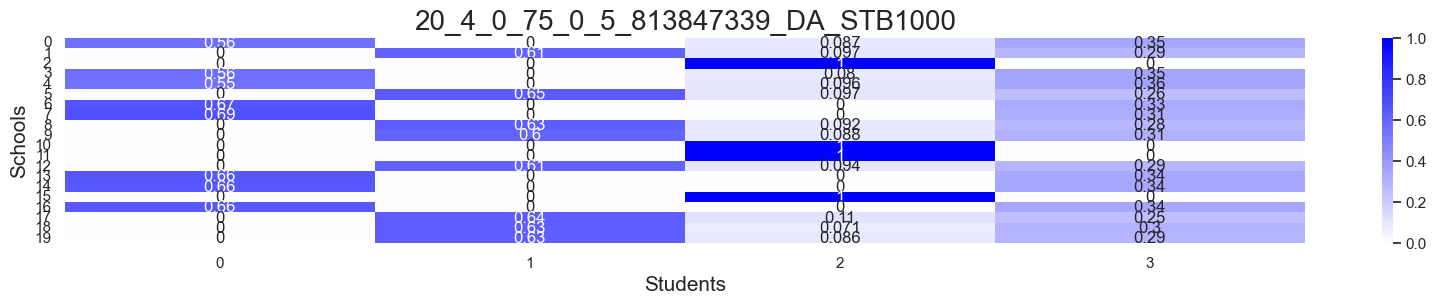

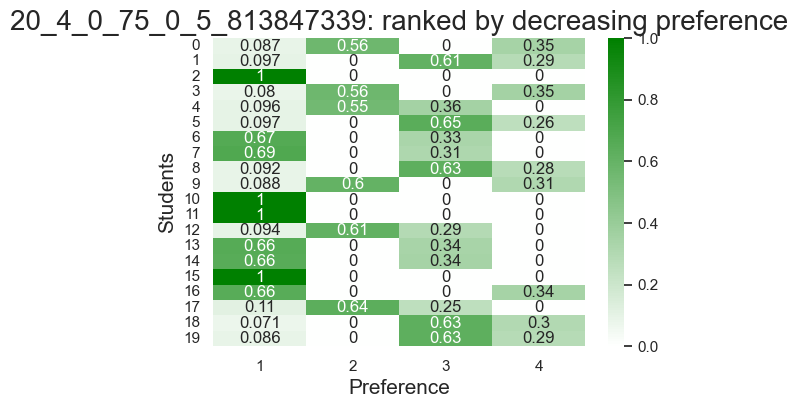

<Figure size 2000x266.667 with 0 Axes>

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 100
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'EE', bool_SIC, 813847339, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 813847339, True)
A_EADAM.statistics(True)

A.visualize()
A.find_identical_students(True)

In [ ]:
# Solve the formulations
bool_identical_students= False
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, bool_identical_students, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)

S = MyModel.Solve("TRAD", "GUROBI", print_log=False, time_limit= 3600, n_sol_pricing= 5, gap_solutionpool_pricing=0.1, MIPGap=0.001, bool_ColumnGen=True, bool_supercolumn= True, print_out=True)
 
#S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 600, n_sol_pricing = 100, gap_solutionpool_pricing= 0.2, MIPGap = 0.1, bool_ColumnGen= True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 961/961 [00:00<00:00, 2784.28var/s]
c:\Users\P70096165\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")



Average rank DA : 2.1296000000000004.


Average rank warm start solution : 2.129600000000001.




Pricing exclude found matchings: 100%|██████████| 961/961 [00:00<00:00, 1632.30matchings/s]

Number of matchings: 961

ITERATION: 1

 ****** MASTER ****** 

Set parameter Username
Set parameter LicenseID to value 2712222
Academic license - for non-commercial use only - expires 2026-09-23


Objective master:  2.129600000000001
Constant term 1.6000000000000014

 ****** PRICING ****** 

New time limit 3599.8156337998807
self.obj_pricing_var:  1.1
Constant term: 1.6000000000000014
		Objective pricing:  1.1
Pricing status 1
Solutions found by pricing: 5
Matching  962 Objective value pricing: 1.0999999999999999
Matching  966 Objective value pricing: 1.0999999999999992
New number of matchings: 966

ITERATION: 2

 ****** MASTER ****** 

Objective master:  2.129600000000001
Constant term 1.5999999999999994

 ****** PRICING ****** 

New time limit 3597.9188004999887
self.obj_pricing_var:  1.100000000000001
Constant term: 1.5999999999999994
		Objective pricing:  1.100000000000001
Pricing status 1
Solutions found by pricing: 5
Matching  967 Objective value pricing: 1.100000000000001
Matching  971 Objective value pricing: 1.0500000000000005
New number of matchings: 971

ITERATION: 3

 ****** MASTER ****** 

Objective master:  2.129600000000001
Constant term 1.5999999999999996

 *****

In [ ]:
#print(len(S.Xdecomp))
#print(len(MyModel.w))
#print(A_EADAM.statistics())
print(S.A.statistics())
#A_EADAM.visualize()
#S.A.visualize()
S.A.compare(A.assignment, True)
#print(S.avg_ranks)

In [ ]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


In [ ]:
# # Asses and visualize the difference
# name_diff = MyData.file_name + '_diff'
# diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
# diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
# diff.visualize() # Difference compared to DA
# diffEE.visualize() # Difference compared to EE

# Simulations

In [ ]:
#n_students_schools = [[100,2],[200,4],[400,8], [800, 16], [1600, 32], [3200, 64]]
n_students_schools = [[200,4],[200,8],[200,12], [200, 16], [200, 20], [200, 24], [200, 28], [200, 32]]

compare_solutions = ["SD_UPON_DA", "SD_UPON_EE", "SD_UPON_EADA"]
    # All options are: ["SD_UPON_DA", "SD_UPON_EE", "SD_UPON_EADA"]

n_iterations_simul = 10
n_match = 1000
time_lim = 60
n_sol_pricing = 20
gap_solutionpool_pricing = 0.15 
MIPGap = 0.05
bool_ColumnGen = False
bool_identical_students = False

seed = 0

#ALPHA_INCREMENT = 0.20
#BETA_INCREMENT = 0.5

#alpha = list(np.arange(0, 1.0, ALPHA_INCREMENT)) + [1.0]
#beta = list(np.arange(0, 1.0, BETA_INCREMENT)) + [1.0]
alpha = [0.25]
beta = [0.5]


S_vector = SimulationCG(compare_solutions, n_students_schools, alpha, beta, n_iterations_simul, n_match, time_lim, seed, n_sol_pricing, gap_solutionpool_pricing, MIPGap, bool_ColumnGen, bool_identical_students, True)


In [ ]:
SimulationsEvaluate("SIM_2025-07-29_131019", False)

## Estonian data

In [2]:
file_path = "ReadData/Estonia/data_anon.txt" 
MyData = read_dataEstonia(file_path)
print(MyData)

The data instance has the following properties: 

	152 students.
	7 schools. 

 	PREFERENCES:
	1	2 3 6 5 7 1 4 
	2	4 3 6 7 5 2 1 
	3	2 5 3 6 7 1 4 
	4	5 7 2 3 6 1 4 
	5	6 3 5 7 2 1 4 
	6	2 3 5 7 1 6 4 
	7	3 6 2 5 7 1 4 
	8	4 1 2 3 6 7 5 
	9	6 3 2 5 7 1 4 
	10	5 3 2 7 1 6 4 
	11	3 2 5 4 6 7 1 
	12	5 2 1 7 6 3 4 
	13	2 3 5 7 6 1 4 
	14	4 1 3 2 5 7 6 
	15	6 3 2 1 5 4 7 
	16	5 2 7 3 1 6 4 
	17	2 5 3 7 6 1 4 
	18	3 6 2 5 4 1 7 
	19	6 3 2 5 7 1 4 
	20	7 5 2 4 3 6 1 
	21	3 6 2 5 7 1 4 
	22	2 5 7 3 1 4 6 
	23	6 2 5 3 7 1 4 
	24	5 3 2 7 1 6 4 
	25	2 5 3 6 1 7 4 
	26	3 2 5 7 1 6 4 
	27	2 6 3 5 4 7 1 
	28	2 3 4 1 5 6 7 
	29	2 5 3 6 7 4 1 
	30	6 3 4 2 5 7 1 
	31	6 3 2 5 7 1 4 
	32	5 6 3 7 1 4 2 
	33	6 3 5 2 1 7 4 
	34	5 3 2 7 6 1 4 
	35	6 3 2 5 7 1 4 
	36	3 2 5 1 7 6 4 
	37	1 2 4 5 7 6 3 
	38	2 5 3 6 7 1 4 
	39	7 1 2 5 6 3 4 
	40	2 3 1 5 6 4 7 
	41	2 3 6 5 7 1 4 
	42	3 5 7 2 6 1 4 
	43	3 2 5 6 7 1 4 
	44	2 6 3 5 4 1 7 
	45	5 7 3 1 2 6 4 
	46	2 3 6 5 4 1 7 
	47	5 2 3 7 6 4 1 
	48	3 2 5 6 7 1 4 
	49

In [3]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 0, True)

print(A.assignment)
A.statistics()
A_SIC.statistics()
A_EADAM.statistics()

Students in ties: 152
Tie-breaking rules sampled: 1000


Generate DA_STB: 100%|██████████| 1000/1000 [00:23<00:00, 42.23perturb/s]


STATISTICS BEFORE:

Average rank: 1.8237565789473678.



Compute SICs for matchings: 100%|██████████| 1000/1000 [00:03<00:00, 322.83matching/s]


STATISTICS AFTER:

Average rank: 1.8015394736842112.

Students in ties: 152
Tie-breaking rules sampled: 1000


Generate EADAM_STB: 100%|██████████| 1000/1000 [00:11<00:00, 90.44perturb/s]


[[0.    0.645 0.355 ... 0.    0.    0.   ]
 [0.055 0.    0.    ... 0.    0.    0.   ]
 [0.    0.665 0.095 ... 0.24  0.    0.   ]
 ...
 [0.    0.    0.296 ... 0.    0.704 0.   ]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.073 0.    0.    ... 0.    0.    0.   ]]


np.float64(1.79995394736842)

In [4]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, False, True)
#MyModel = ModelColumnGen(MyData, A_SIC, A_EADAM.assignment, False, True) # Compare to A_EADAM

timeLimit = 360
S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= timeLimit, n_sol_pricing = 2, gap_solutionpool_pricing = 0.2, MIPGap= 0.1, bool_ColumnGen=True, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 1000/1000 [00:11<00:00, 89.16var/s]



Average rank DA : 1.8237565789473678.


Average rank warm start solution : 1.8015394736842112.




c:\Users\P70096165\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Pricing exclude found matchings: 100%|██████████| 1000/1000 [00:21<00:00, 46.32matchings/s]

Number of matchings: 1000
ITERATION: 1

 ****** MASTER ****** 

Set parameter Username
Set parameter LicenseID to value 2712222
Academic license - for non-commercial use only - expires 2026-09-23


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1059 rows, 1000 columns and 936504 nonzeros
Model fingerprint: 0x416e0f19
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve removed 898 rows and 0 columns
Presolve time: 0.27s
Presolved: 161 rows, 1000 columns, 108475 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.288e+04
 Factor NZ  : 1.304e+04 (roughly 1 MB of memory)
 Factor Ops : 1.404e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    D

In [10]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


{'students_improving': [False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, True, False, True, True, False, True, True, False, False, False, False, False, True, False, False, False, False, True, False, False, False, True, False, False, False, False, False, True, True, False, True, False, True, False, False, True, True, False, True, False, True, True, True, False, False, False, True, True, False, True, False, False, False, False, True, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, True, False, True, False, False, True, True, True, False, True, False, False, False, True, False, False, False, True, False, False, True, False, False, False, False, False, True, False, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False

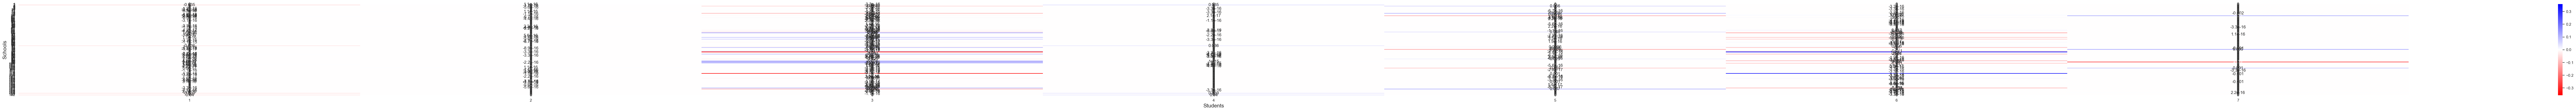

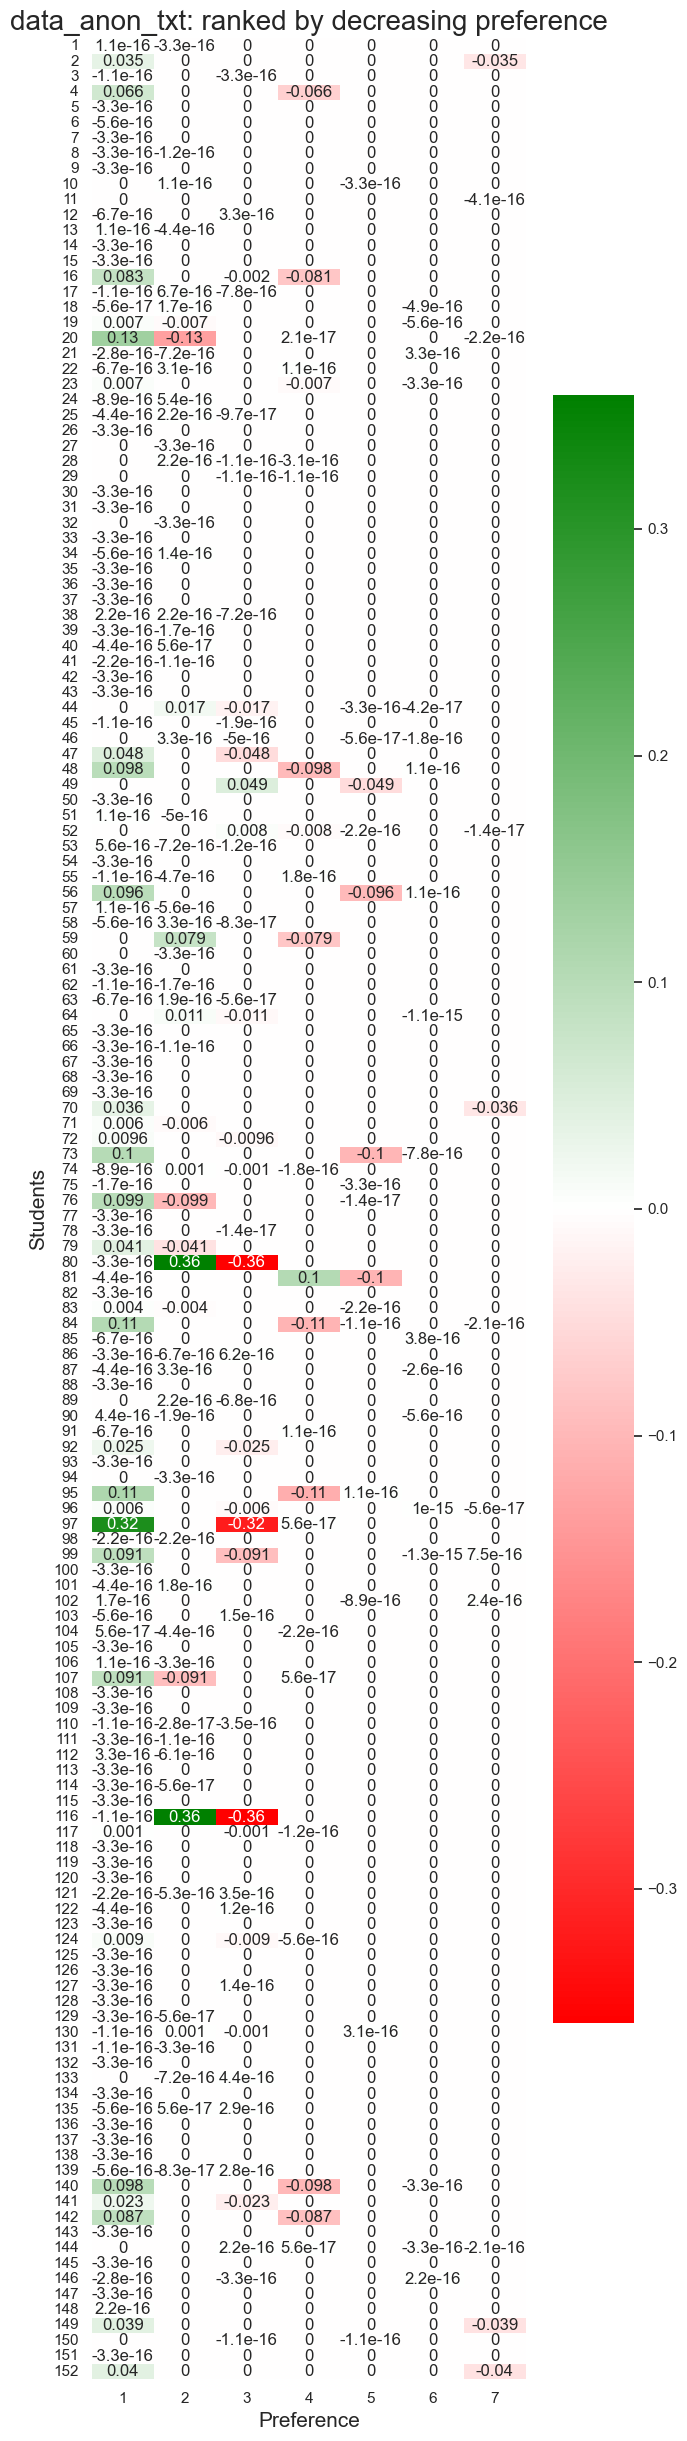

<Figure size 15200x466.667 with 0 Axes>

In [13]:
A_diff = Assignment(MyData, S.A.assignment - A.assignment)
A_diff.visualize()

In [ ]:
# Generate a second subset of matchings, and test column generation with that
# (10 June 2025: not yet configured for use of warm start)
n_iter = 1000
bool_SIC = True # Run SICs immediately?
B = DA_STB(MyData, n_iter, 'GS', bool_SIC, 1, True)
B_SIC = SIC_all_matchings(MyData, B, True)
A_SIC.M_set = copy.deepcopy(B_SIC.M_set)
MyModel2 = ModelColumnGen(MyData, A_SIC, A.assignment, True)
qq = MyModel2.Solve("TRAD", "GUROBI", print_log=True, print_out=False)


## Run initial IP on generated data
Specify the number of students and schools, and run the models for this data.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 6, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=1000, n_schools=50, parameters = parameters, name="Test_DataGen_EE_vs_GS", print_data=False, seed = 0)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 20
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, q.assignment - A.assignment, name_diff)
diff.visualize()

## Heuristic subset weakly stable matchings
Runs an LP that minimizes the average rank while stochastically dominating the DA assignment with single-tie breaking, and while only using matchings that were used to compute DA probabilities. This is a heuristic.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=10, n_schools=4, parameters = parameters, name="500_25", print_data=False, seed = 1)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModel = ModelHeuristicLP(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
print(np.max(q.assignment-A.assignment))

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - A.assignment, "40_12_Diff")
diff.visualize()

## Heuristic Fractional stable random matching

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModelFS = ModelFracStable(MyData, A, True)
q = MyModelFS.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# FInd decomposition over weakly stable matchings of this fractionally stable matching (if decomposition exists)
MyModelCHECK = Model(MyData, q, True)
q_check = MyModelCHECK.Solve("STABLE", "GUROBI", True)

## Run code manual data
Manually enter data.

In [2]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

In [3]:
# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


The data instance has the following properties: 

	4 students.
	4 schools. 

 	PREFERENCES:
	A	1 3 4 2 
	B	1 4 3 2 
	C	2 3 4 1 
	D	2 4 3 1 


 	CAPACITIES & PRIORITIES:
	1	1	{A B} C D 
	2	1	{C D} A B 
	3	1	B D {A C} 
	4	1	A C {B D} 



In [4]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

A_EADAM = EADAM_STB(MyData, n_iter, 0, True)

print(A.assignment)
A.statistics()
A_SIC.statistics()
A_EADAM.statistics()

Students in ties: 4
Tie-breaking rules needed: 24
Tie-breaking rules sampled: 24


Generate DA_STB: 100%|██████████| 24/24 [00:00<00:00, 3038.43perturb/s]


STATISTICS BEFORE:

Average rank: 1.625.



Compute SICs for matchings: 100%|██████████| 6/6 [00:00<00:00, 2011.50matching/s]


STATISTICS AFTER:

Average rank: 1.625.

Students in ties: 4
Tie-breaking rules needed: 24
Tie-breaking rules sampled: 24


Generate EADAM_STB: 100%|██████████| 24/24 [00:00<00:00, 1909.61perturb/s]

[[0.5   0.    0.375 0.125]
 [0.5   0.    0.125 0.375]
 [0.    0.5   0.375 0.125]
 [0.    0.5   0.125 0.375]]


np.float64(1.625)

In [5]:
# Remove matchings from generated set
# for i in A.M_set:
#    print(i)

    # Remove specific matching
#    M = np.zeros(shape=(MyData.n_stud, MyData.n_schools))
    #M[0][0] = 1
    #M[1][3] = 1
    #M[2][2] = 1
    #M[3][1] = 1
#    M[0][2] = 1
#    M[1][0] = 1
#    M[2][1] = 1
#    M[3][3] = 1
#    remove1=tuple(map(tuple, M))

#A.M_set.remove(remove1)

#print("New")

#for i in A.M_set:
#    print(i)

# Define empty assignment object
A_empty = deepcopy(A)
A_empty.M_set = set()
print(A_empty.M_set)

set()


In [46]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_empty, A.assignment, False, True)

S = MyModel.Solve("TRAD", "GUROBI", print_log=True, time_limit= 3600, n_sol_pricing= 1, gap_solutionpool_pricing=0, MIPGap=0, bool_ColumnGen=True, bool_supercolumn= True, print_out=True)
                    
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 0var [00:00, ?var/s]



Average rank DA : 1.625.


Average rank warm start solution : 1.625.




Pricing exclude found matchings: 0matchings [00:00, ?matchings/s]

Number of matchings: 0

ITERATION: 1

 ****** MASTER ****** 

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 1 columns and 0 nonzeros
Model fingerprint: 0xa981e80e
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+00]
Presolve time: 0.00s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible model
Gurobi status= 3
Objective master:  None

 Supercolumn added to model to enforce feasibility.

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using u

Found heuristic solution: objective 640032.25000
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolved: 6 rows, 7 columns, 20 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)

Root relaxation: objective 6.400325e+05, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    640032.50000 640032.500  0.00%     -    0s

Explored 1 nodes (1 simplex iterations) in 0.12 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 640033 
No other solutions better than 640033

Optimal solution found (tolerance 0.00e+00)
Best objective 6.400325000000e+05, best bound 6.400325000000e+05, gap 0.0000%
Gurobi status= 2
self.obj_pricing_var:  640034.0
Constant term: 1.5
		Objective pricing:  640034.0
Pricing status 1
Solutions found by pricing: 1
Matching  3 Objective value 

In [47]:
# Print the solution
print(S.Xdecomp)
print(S.Xdecomp_coeff)

[array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]]), array([[ 1.,  0., -0.,  0.],
       [-0.,  0.,  0.,  1.],
       [ 0., -0.,  1., -0.],
       [ 0.,  1., -0., -0.]])]
[0.0, 0.5, 0.5]


In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - p, "Ex_paper_Diff")
diff.visualize()

In [ ]:
tuple([1,2])

# Erdil & Ergin experiments

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Do tie-breaking
permut = generate_permutations_STB(MyData, 1, seed = 3)

prior_new = generate_strict_prior_from_perturbation(MyData, permut[0])

Data_new_prior = Data(MyData.n_stud, MyData.n_schools, MyData.pref, prior_new, MyData.cap, MyData.ID_stud, MyData.ID_school, MyData.file_name)

# DA code Erdil & Ergin
N = transform_pref_us_to_EE(Data_new_prior)
A = transform_prior_us_to_EE(Data_new_prior)
Q = MyData.cap
result = DA_Erdil_ergin(N,A,Q)
print(result)
print(type(result['proposeoffset']))

M = gale_shapley(Data_new_prior)
print(type(M))
print(M)

M = np.zeros((4,4))
M[0,1] = 1
M[1,2] = 1
M[2,3] = 1
M[3,0] = 1
print(M)
print(M[0,1] == 1)

M_out = SIC(MyData, M, False)
print(M_out)

In [ ]:
bool_SIC = False # Run SICs immediately?
AssignmentGS = DA_STB(MyData, 10, 'GS', bool_SIC, 0)
ASIC = SIC_all_matchings(MyData, AssignmentGS, True)

print(AssignmentGS.assignment)




# EADAM tests

In [ ]:
# Example paper Tang & Yu (2014)
n_stud = 4
n_schools = 4

file_name = "Ex_paper_TangYu"

# Preferences students
pref = [[1, 0],
        [0, 2],
        [0, 1],
        [2, 3]]

# Priorities schools
prior = [[0, 1, 2],
         [2, 0],
         [1, 3],
        [3]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = [0, 1, 2, 3]
ID_school = [0, 1, 2, 3]

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)
consent = [1, 1, 1, 1]


In [ ]:
# Example 3 paper Kesten 
n_stud = 6
n_schools = 5

file_name = "Ex3_paper_Kesten"

# Preferences students
pref = [[2, 1, 3],
        [3, 1, 5],
        [3, 4, 2],
        [1, 2, 4],
        [1, 5],
        [4,1,3,2,5]]

# Priorities schools
prior = [[2,1,5,6,4,3],
         [3,6,4,1,2,5],
         [1,6,2,3,4,5],
        [4,3,6,1,2,5],
        [1,2,3,4,5,6]]


# Capacities schools
cap = [1,1,1,1,2]

# Names of students and schools
ID_stud = [1, 2, 3, 4, 5, 6]
ID_school = [1, 2, 3, 4, 5]

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)
consent = [1,1,1,1,1,1]


In [ ]:
M = EADAM(MyData, consent, False)
print(M)

# Quick tests


In [ ]:
n_stud = 2000
n_schools = 30
pref_list_length = n_schools
alpha_in = 0.2
beta_in = 0
seed = 1
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)


In [ ]:
ALPHA_INCREMENT = 0.2
BETA_INCREMENT = 0.4

alpha_list = list(np.arange(0, 1.0, ALPHA_INCREMENT)) 
beta_list = list(np.arange(0, 1.0, BETA_INCREMENT))

print(alpha_list)
print(type(alpha_list))


In [ ]:
M = np.zeros((5,3))
M[0,1] = 1
M[0,2] = 1
print(sum(M[0]))
print(sum(M[1]))

In [ ]:
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

pref[1].remove('4')
print(pref)

In [ ]:
T = range(5)
print(len(T))

In [ ]:
np.empty(shape=(3, 4))

In [ ]:
test = LpProblem('Test', LpMaximize)
X1 = LpVariable('X1', 0, 10)
X2 = LpVariable('X2', 0, 10)
test+= X1 + X2 <= 5
test += X1 + X2 +1000000
test.writeLP('Test.lp')
solver_function = globals()['GUROBI']
test.solve(solver_function())
print('\nOptimal objective value is', value(test.objective))



i 1  of  3
i 2  of  3
i 3  of  3
    n_stud  n_schools  alpha  beta       seed     DiffHeur1     DiffHeur2  \
0      100         10    0.0   0.5  906691059  1.842081e-01  1.736704e-01   
1      100         10    0.0   0.5  413653999  1.313263e-01  1.245442e-01   
2      100         10    0.0   0.5  813847339  1.125300e-01  9.888242e-02   
3      100         10    0.0   0.5  955892128  9.423228e-02  8.516871e-02   
4      100         10    0.0   0.5  451585301  9.607735e-02  8.229956e-02   
5      100         10    0.2   0.5  906691059  2.510561e-01  2.390913e-01   
6      100         10    0.2   0.5  413653999  1.373610e-01  1.303504e-01   
7      100         10    0.2   0.5  813847339  1.452307e-01  1.310224e-01   
8      100         10    0.2   0.5  955892128  1.197521e-01  1.104341e-01   
9      100         10    0.2   0.5  451585301  1.319498e-01  1.201172e-01   
10     100         10    0.4   0.5  906691059  1.284728e-01  1.249663e-01   
11     100         10    0.4   0.5  4136539

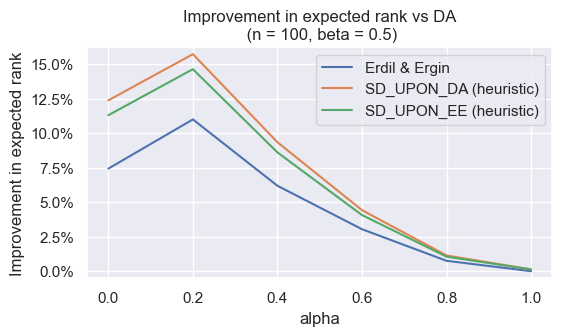

In [24]:
SimulationsEvaluate("SIM_2025-07-29_115642", False)

    x  bar_value  line_value
0   1   4.405579    0.869304
1   2   1.318106    0.135648
2   3   7.132610    0.248829
3   4   6.338605    0.855828
4   5   2.630714    0.350099
5   6   7.197983    0.250332
6   7   7.661820    0.435351
7   8   1.547008    0.296369
8   9   3.574242    0.460080
9  10   6.549910    0.015991


KeyError: 'bar_percent'

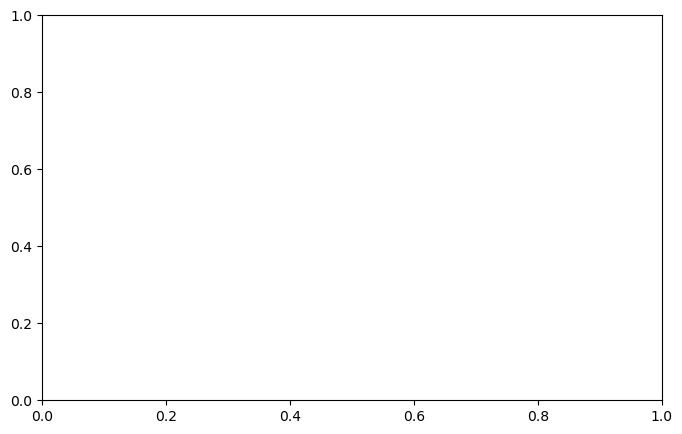

In [ ]:
# Example DataFrame
df = pd.DataFrame({
    'x': range(1, 11),
    'bar_value': np.random.uniform(0, 10, 10),
    'line_value': np.random.uniform(0, 1, 10)  # already in percentage form (0–1)
})
print(df)

# Convert both to percentages
df['bar_percent'] = 100 * df['bar_value'] / 10   # since bar_value ranges 0–10
df['line_percent'] = 100 * df['line_value']      # since line_value ranges 0–1

# Plot both on same axis
fig, ax = plt.subplots(figsize=(8, 5))

# Bar plot
ax.bar(df['x'], df['bar_percent'], color='skyblue', alpha=0.6, label='Bar value (%)')

# Line plot
ax.plot(df['x'], df['line_percent'], color='orange', marker='o', linewidth=2, label='Line value (%)')

# Axis formatting
ax.set_xlabel('Observation')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.set_xticks(df['x'])
ax.legend()
plt.title('Bars and Line on Same Percentage Scale')

plt.tight_layout()
plt.show()
